In [1]:
import sys
import logging
import importlib
import itertools
from pathlib import Path

import numpy as np  # type: ignore
from matplotlib import pyplot as plt  # type: ignore

sys.path.append('../../src/')
import utils.figures  # type: ignore # noqa: E402

In [2]:
data_dir = Path('../../data/')

In [3]:
importlib.reload(utils)
from utils.figures import load_all_eliminateds_dict  # noqa: E402
logging.basicConfig(level=logging.DEBUG, stream=sys.stdout)
eliminateds = load_all_eliminateds_dict(data_dir)
logging.basicConfig(level=logging.WARNING, stream=sys.stderr)

DEBUG:root:Loading positive-eliminated from ../../data/benchmark_results/all-full-flat-spencer-none.jsonl
DEBUG:root:Loading positive-eliminated from ../../data/benchmark_results/all-full-flat-spencer-cn.jsonl
DEBUG:root:Loading positive-eliminated from ../../data/benchmark_results/all-full-flat-spencer-in.jsonl


In [4]:
importlib.reload(utils)
from utils.figures import load_steps_dict  # noqa: E402
logging.basicConfig(level=logging.DEBUG, stream=sys.stdout)
steps = load_steps_dict(data_dir)
logging.basicConfig(level=logging.WARNING, stream=sys.stderr)

DEBUG:root:Loading positive-step from ../../data/benchmark_results/all-full-thompson-spencer-none.jsonl
DEBUG:root:Loading negative-step from ../../data/benchmark_results/all-full-thompson-spencer-none.jsonl
DEBUG:root:Loading positive-step from ../../data/benchmark_results/all-full-thompson-spencer-cn.jsonl
DEBUG:root:Loading negative-step from ../../data/benchmark_results/all-full-thompson-spencer-cn.jsonl
DEBUG:root:Loading positive-step from ../../data/benchmark_results/all-full-thompson-spencer-in.jsonl
DEBUG:root:Loading negative-step from ../../data/benchmark_results/all-full-thompson-spencer-in.jsonl
DEBUG:root:Loading positive-step from ../../data/benchmark_results/all-full-thompson-lockstep-none.jsonl
DEBUG:root:Loading negative-step from ../../data/benchmark_results/all-full-thompson-lockstep-none.jsonl
DEBUG:root:Loading positive-step from ../../data/benchmark_results/all-full-flat-spencer-none.jsonl
DEBUG:root:Loading negative-step from ../../data/benchmark_results/all-ful

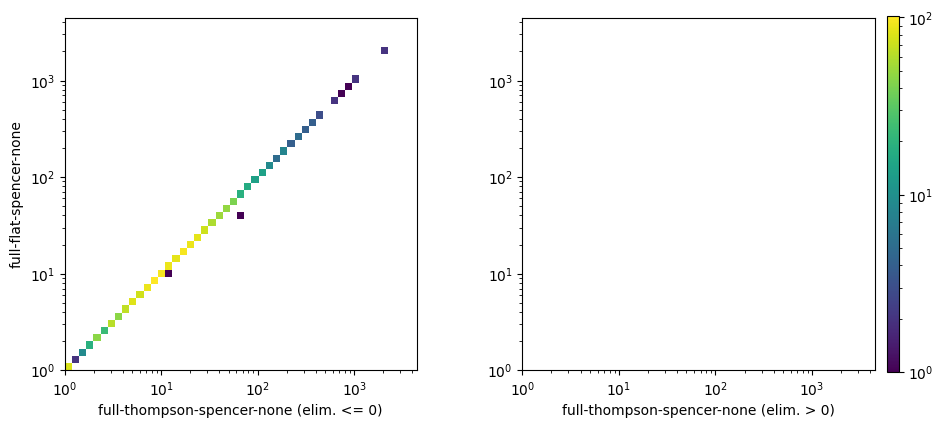

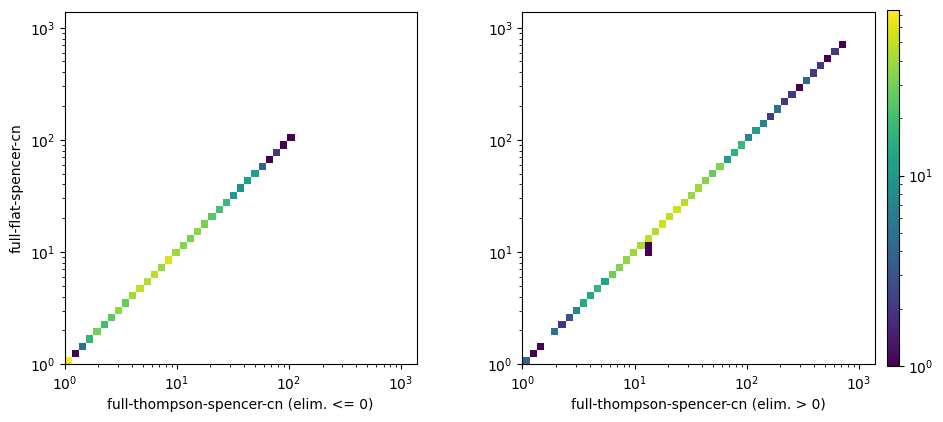

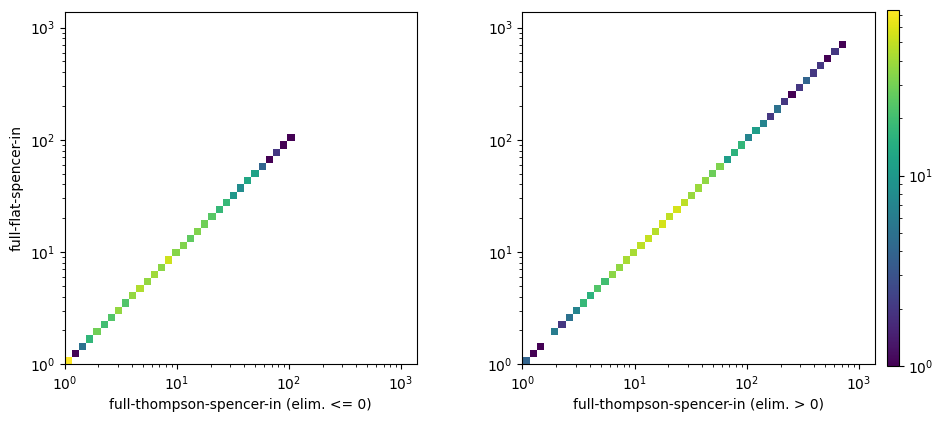

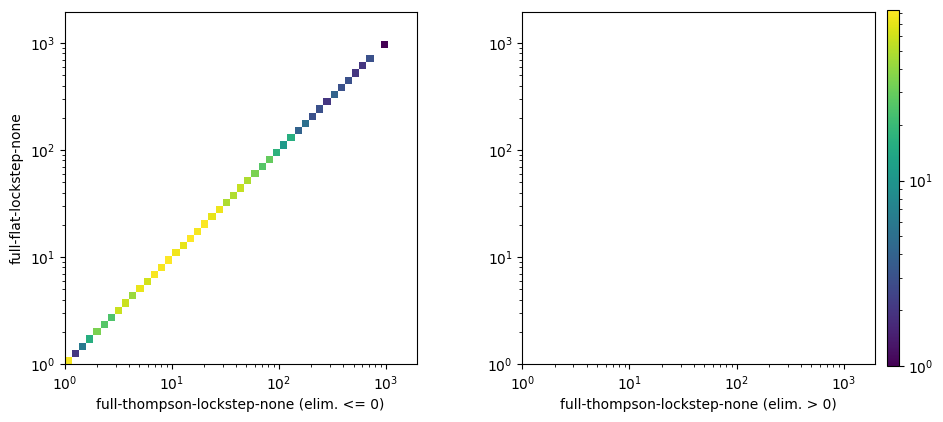

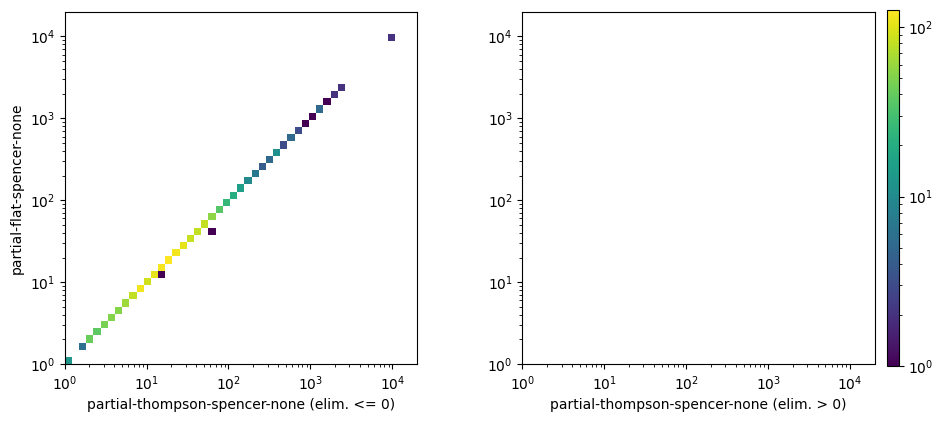

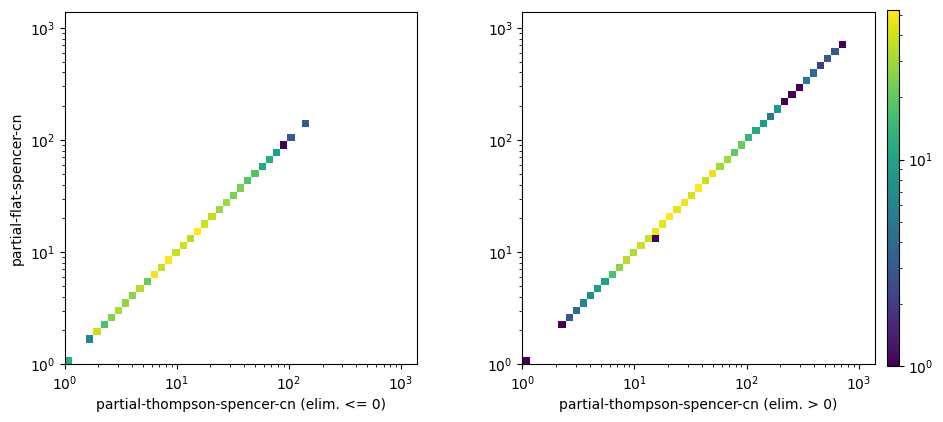

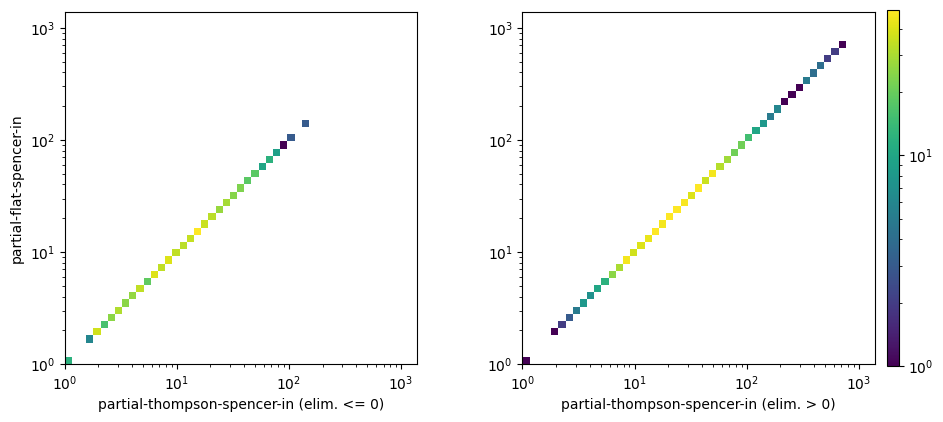

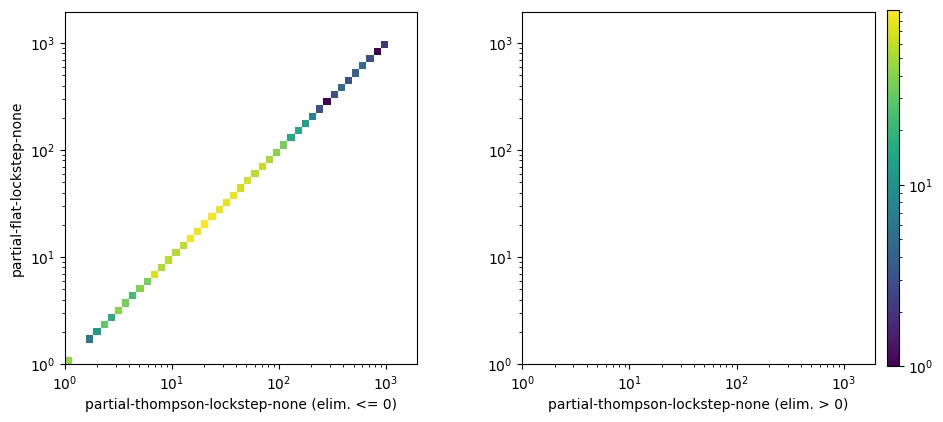

In [5]:
# Histogram 2D
importlib.reload(plt)

logging.basicConfig(level=logging.WARNING, stream=sys.stderr, force=True)
options = itertools.product(
    ['full', 'partial'],
    [('spencer', 'none'), ('spencer', 'cn'),
     ('spencer', 'in'), ('lockstep', 'none')]
)
threshold = 0

for matching_type, (scheduler, memo_scheme) in options:
    input_types = ['positive', 'negative']
    xs = np.concatenate([
        steps[matching_type]['thompson'][scheduler][memo_scheme][input_type]
        for input_type in input_types
    ])
    xlabel = "-".join([matching_type, 'thompson', scheduler, memo_scheme])
    ys = np.concatenate([
        steps[matching_type]['flat'][scheduler][memo_scheme][input_type]
        for input_type in input_types
    ])
    ylabel = "-".join([matching_type, 'flat', scheduler, memo_scheme])
    zs = np.concatenate(
        [eliminateds[memo_scheme][input_type] for input_type in input_types])
    # Range excluding outliers
    total = xs + ys
    quartile_1 = np.quantile(total, 0.25)
    quartile_3 = np.quantile(total, 0.75)
    iqr = quartile_3 - quartile_1
    maximum = np.max(
        total, where=xs <= quartile_3 + 1.5 * iqr, initial=-np.inf)
    minimum = np.min(total, where=xs >= quartile_1 - 1.5 * iqr, initial=np.inf)
    x_space = np.geomspace(1, max(xs+ys), 50)
    y_space = np.geomspace(1, max(ys+ys), 50)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    h, _, _, cmap = axes[0].hist2d(
        xs[zs <= threshold], ys[zs <= threshold],
        bins=(x_space, y_space), vmin=1, norm='log'
    )
    axes[0].set_xscale('log')
    axes[0].set_yscale('log')
    axes[0].set_xlabel(xlabel + f" (elim. <= {threshold})")
    axes[0].set_ylabel(ylabel)
    axes[0].axis('square')

    vmax = np.max(h)

    axes[1].hist2d(xs[zs > threshold], ys[zs > threshold], bins=(
        x_space, y_space), norm='log', vmin=1, vmax=vmax)
    axes[1].set_xscale('log')
    axes[1].set_yscale('log')
    axes[1].set_xlabel(xlabel + f" (elim. > {threshold})")
    axes[1].axis('square')

    fig.subplots_adjust(right=0.8)
    axes[1].get_position()
    pos = axes[1].get_position()
    cbar_ax = fig.add_axes(
        [pos.x1 + 0.01, pos.y0 + 0.01, 0.01, pos.y1 - pos.y0 - 0.02])
    fig.colorbar(cmap, cax=cbar_ax)

    plt.subplots_adjust(wspace=0.3)
    output_dir = Path('./outputs/step')
    output_dir.mkdir(parents=True, exist_ok=True)
    filename = "-".join([matching_type, scheduler, memo_scheme]) + '.pdf'
    plt.savefig(output_dir / filename)
    plt.show()

In [6]:
%%script echo
# Scatter plot
logging.basicConfig(level=logging.INFO, stream=sys.stderr, force=True)
plt.scatter(xs[zs < threshold], ys[zs < threshold], c='blue')
plt.scatter(xs[zs >= threshold], ys[zs >= threshold], c='orange')
plt.xscale('log')
plt.yscale('log')
plt.axis('square')
plt.show()

In [7]:
%%script echo
# Atan Histogram
normalized_theta = (np.arctan2(xs, ys) - np.pi/4) / (np.pi/4)
plt.hist(normalized_theta, bins=100, range=[-1, 1])
plt.xscale('symlog')
plt.yscale('log')
plt.show()

In [8]:
%%script echo
# Histogram (excluding outliers)
plt.hist([xs, ys], range=(minimum, maximum), log=True, bins=10)
plt.show()

In [9]:
%%script echo
# Histogram 2D
importlib.reload(plt)

for matching_type, (scheduler, memo_scheme) in options:
    input_types = ['positive', 'negative']
    xs = np.concatenate([
        steps[matching_type]['thompson'][scheduler][memo_scheme][input_type]
        for input_type in input_types
    ])
    xlabel = "-".join([matching_type, 'thompson', scheduler, memo_scheme])
    ys = np.concatenate([
        steps[matching_type]['flat'][scheduler][memo_scheme][input_type]
        for input_type in input_types
    ])
    ylabel = "-".join([matching_type, 'flat', scheduler, memo_scheme])
    zs = np.concatenate(
        [eliminateds[memo_scheme][input_type] for input_type in input_types])

    # Range excluding outliers
    total = xs + ys
    quartile_1 = np.quantile(total, 0.25)
    quartile_3 = np.quantile(total, 0.75)
    iqr = quartile_3 - quartile_1
    maximum = np.max(total, where=xs <= quartile_3 +
                     1.5 * iqr, initial=-np.inf)
    minimum = np.min(total, where=xs >= quartile_1 - 1.5 * iqr, initial=np.inf)

    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    for i in range(2):
        _xs = xs[zs <= threshold] if i == 0 else xs[zs > threshold]
        _ys = ys[zs <= threshold] if i == 0 else ys[zs > threshold]
        bins = np.geomspace(1, max(xs+ys), 30)
        plt1, _ = np.histogram(_xs, bins)
        plt2, _ = np.histogram(_ys, bins)
        height = plt2 - plt1
        axs[i].bar(bins[:-1], width=np.diff(bins), height=height, align='edge')
        axs[i].set_xscale('log')

    plt.subplots_adjust(wspace=0.3)
    output_dir = Path('./outputs')
    output_dir.mkdir(parents=True, exist_ok=True)
    filename = "-".join([matching_type, scheduler,
                        memo_scheme]) + '-histdiff.pdf'
    plt.savefig(output_dir / filename)
    plt.show()